# Project: Building an investment portfolio

#### Project tasks:
<ol><li>Create an investment portfolio with a high level of returns and relatively low volatility. To solve this task we will use the next strategy:</li>
    <ul><li>compute daily returns for every financial tool;</li>
        <li> calculate the mean and variance of the daily returns for every financial tool;</li>
        <li> generate 10 000 random sets of weights. Thus we will have 10 000 variants of portfolio structure with different shares of financial tools;</li>
        <li> among all 10 000 portfolios, we will choose one with the highest level of profit and relatively small volitation.</li></ul>
    <p></p>
<li>Predict stock prices for the next 5 days with the Monte Carlo method and with ML algorithm.</li>
    <ul><li> <strong>Monte Carlo Method</strong> - this algorithm includes a simulation of 1000 random returns for each of the 5 required days. Based on this method we can plot the probability density function and cumulative distribution function, which will show us the probability of the specific level of profit (for example probability to earn more than 5 percent per day). Moreover based on generated by this method data we can compute the expectation of stock price for every day.</li>
        <li> <b>Machine Learning algorithm.</b> We will take the simplest one – Linear Regression. For this algorithm, we need to have independent variables and dependent feature. To create a dependent feature we will copy downloaded stock data but shift it for the 5 days forward. Thus we will try to predict based on the stock price in one day what would like it be five days later.</li></ul></ol>

#### Data desсription
For this project stock market data from yahoo was used. In particular prices of FAANG (Facebook, Apple, Amazon, Netflix, Google) shares were taken into account, moreover, gold and oil quotations were added to the project as an alternative way of investment. 
The analyzing period starts from 01.01.2014 and ends on 31.08.2020. This period can be characterized as unstable thus it's more interesting how ML algorithm and Monte Carlo method will handle the task.

In [1]:
#import packages
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import seaborn as sns
import pandas_datareader as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

## Data import and preparation

Import data from yahoo.

In [2]:
def import_stock_data(tickers, start = '2014-01-01', end='2020-08-31'):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start, end=end)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for i in tickers:
            data[i] = wb.DataReader(i, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [3]:
#Create a list of selected tickers 
Tickers = ['AAPL', 'AMZN', 'FB', 'NFLX', 'GOOG', 'GC=F', 'BZ=F']

Tickers_titles = ['AAPL', 'AMZN', 'FB', 'NFLX', 'GOOG', 'GC_F', 'BZ_F']

In [4]:
all_stocks = import_stock_data(Tickers)

In [5]:
#Fill NaN values with ffill method: propagate last valid observation forward to the next valid 
all_stocks = all_stocks.ffill()

## Exploratory data analysis

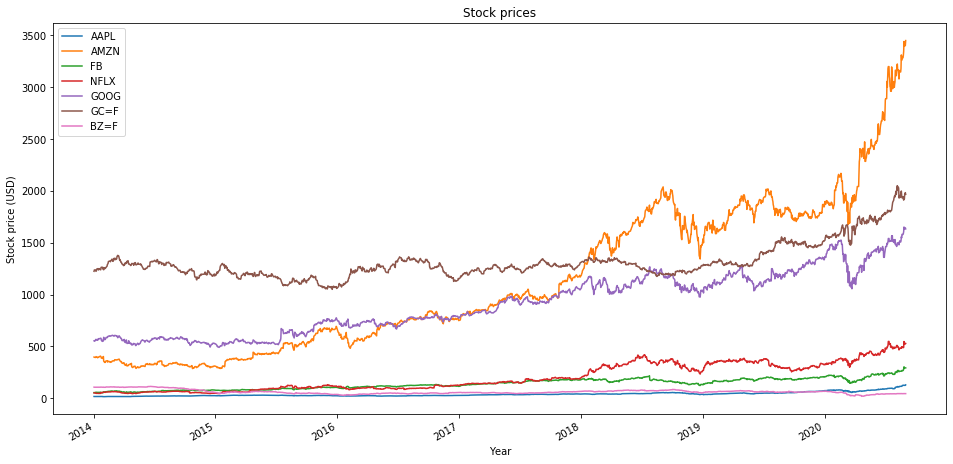

In [6]:
##Let's take a glance on the dataframe

plt.plot(figsize=(16,8))
for i in all_stocks.columns:
    all_stocks[i].plot(label=i, figsize=(16,8))
plt.title('Stock prices')
plt.ylabel('Stock price (USD)')
plt.xlabel('Year')
plt.legend()
plt.show()

We can suppose that some stocks have a correlation between each other, but the visual analysis doesn't give strong evidence about it. To be more precise in our conclusions we need to process correlation analysis.

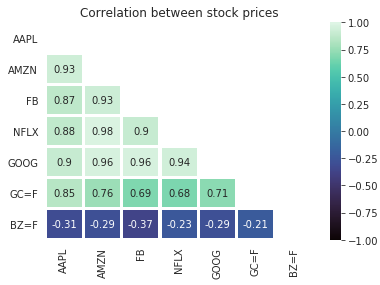

In [7]:
#bottom triangle only
mask = np.zeros_like(all_stocks.corr(method='pearson'))
mask[np.triu_indices_from(mask)] = True
#generate plot
#sns.heatmap(corr_stocks, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
with sns.axes_style("white"):
    # display a correlation heatmap
    ax = sns.heatmap(all_stocks.corr(method='pearson'), mask=mask, annot=True, cmap='mako', vmax=1.0, vmin=-1.0, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
plt.title('Correlation between stock prices')
plt.show()

As we can see from the graph "Correlation between stock prices" FAANG stocks have a strong positive correlation between each other. On the other hand, oil prices have a relatively small negative correlation with other financial tools.

Also, we need to check the distribution of the logarithmic return of the stocks. We plot it to investigate what is the level of volatility of the analyzing financial tools. As we can see on the charts below some financial tools have relatively bigger volatility than others (for example NFLX has a lower level of variance then AAPL and AMZN). It will be useful when we will start to build an investment portfolio and volatility-profit trade-off will appear.

In [8]:
# Calculate the logarithmic daily returns
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [9]:
daily_returns = log_returns(all_stocks)

Let's visualize what we got.

In [10]:
def cool_plots(data, col):
    plt.figure(figsize=(15, 10))
    plt.subplot(2,2,1)
    sns.boxplot(data[col])
    plt.title('Box plot of {}'.format(col), fontsize=20)
    plt.xlabel(col)
    plt.subplot(2,2,2)
    sns.distplot(data[col])
    plt.title('{} distribution'.format(col), fontsize=20)
    plt.xlabel(col)
    plt.ylabel('% of all')
    plt.subplots_adjust(bottom=0.25, top=0.75)
    plt.show()

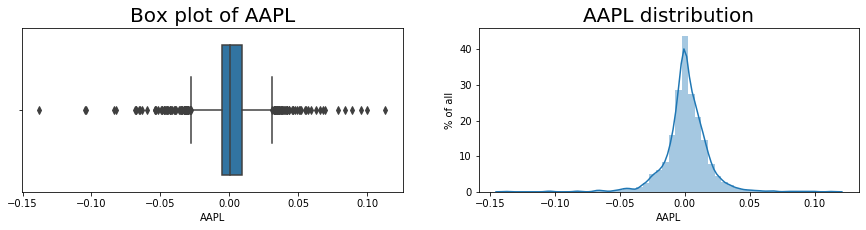

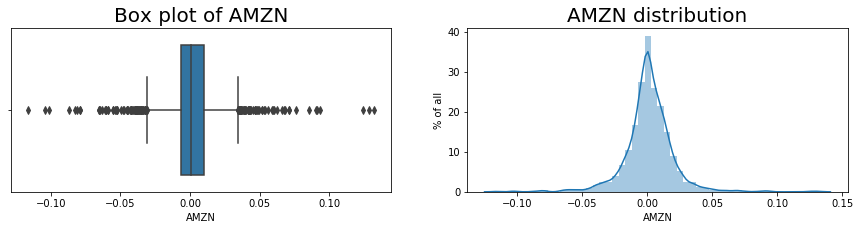

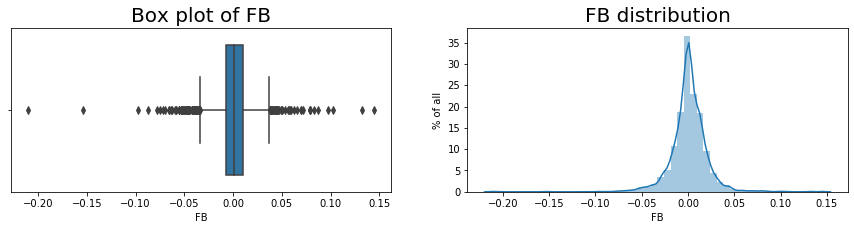

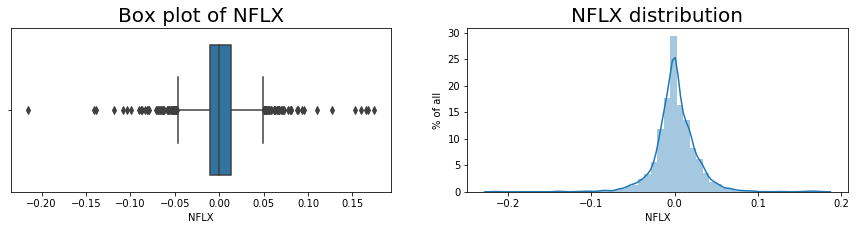

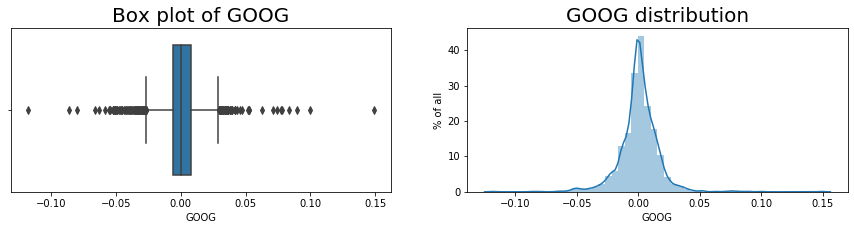

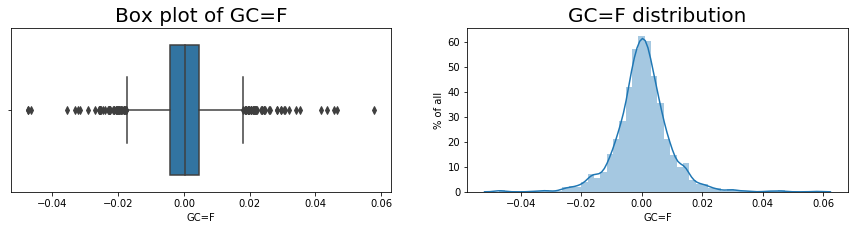

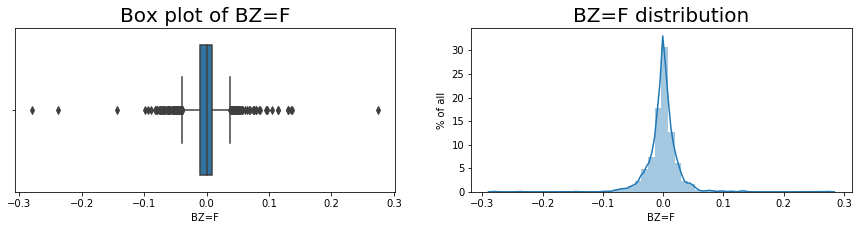

In [11]:
for col in daily_returns.columns:
        cool_plots(daily_returns, col)

## Task 1. Define a portfolio structure

We need to define an optimal portfolio structure based on financial tools' daily profit and volitation. We can't use the logarithmic returns here because it doesn't work right with weights. Thus for this segment, we will deal with simple (discrete) returns.



In [12]:
simple_returns_daily=all_stocks.pct_change()

In [13]:
av_returns = simple_returns_daily.mean()
cov_returns = simple_returns_daily.cov()
std_returns = simple_returns_daily.std()

#### Generate weights for 10000 portfolios

In [14]:
#generate weights
np.random.seed(5)
weights = pd.DataFrame(np.random.randint(0,100,size=(10000, 7)), columns=simple_returns_daily.columns)

In [15]:
#normalize weights as sum must be = 1
weights=weights.div(weights.sum(axis=1), axis=0)

#### Calculate returns on portfolios

In [16]:
#calculate returns by applying weights
#to have yearly return *252 (where 252 - the number of working days)
portfolios_returns = (weights.AAPL*av_returns['AAPL']+weights.AMZN*av_returns['AMZN']+weights['BZ=F']*av_returns['BZ=F']+weights.FB*av_returns['FB']+weights['GC=F']*av_returns['GC=F']+weights.GOOG*av_returns['GOOG']+weights.NFLX*av_returns['NFLX']  )*252

In [17]:
portfolios_returns = pd.DataFrame(portfolios_returns, columns=['returns'])

#### Volatility on portfolios

In [18]:
portfolio_std = pd.DataFrame({'key1': [], 'STD': []})
for i in range(10000):
    std=np.sqrt(np.dot(weights.iloc[i].T,np.dot(cov_returns, weights.iloc[i]))) * np.sqrt(252)
    portfolio_std = portfolio_std.append({'key1': i, 'STD': std}, ignore_index=True)

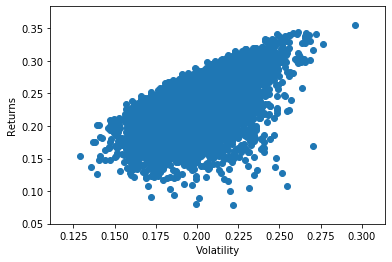

In [19]:
plt.scatter(portfolio_std.STD,portfolios_returns, cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

#### Find the optimal portfolio structure

In [20]:
result = pd.merge(portfolio_std, portfolios_returns, how='inner', left_index=True, right_index=True)

Sort merged dataframe by 'returns' column

In [21]:
result = result.sort_values(by=['returns'], axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False)

From the top 5 portfolios with the largest returns let's find a case with the smallest standard deviation.

In [22]:
opt_portf = result.loc[:5,'STD'].idxmin()

In [23]:
portfolios_returns.iloc[opt_portf]

returns    0.289835
Name: 5202, dtype: float64

In [24]:
portfolio_std.iloc[opt_portf]

key1    5202.000000
STD        0.198818
Name: 5202, dtype: float64

This portfolio was chosen from the top 5 most profitable options but with the smallest variance among them.
The structure of the selected portfolio was:

In [25]:
w_opt_porf = weights.iloc[opt_portf]
print(w_opt_porf)

AAPL    0.255208
AMZN    0.236979
FB      0.070312
NFLX    0.195312
GOOG    0.031250
GC=F    0.208333
BZ=F    0.002604
Name: 5202, dtype: float64


## Task 2 Build a forecast for the stock returns

### Monte Carlo method
For this segment we will use The Brownian  equtations:
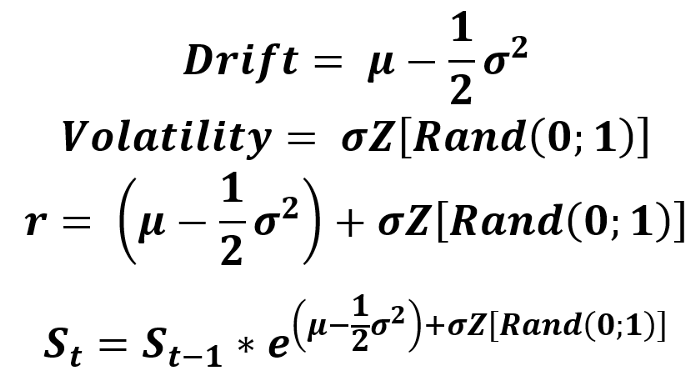
You can find more here https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662

First of all let's create a function for drift computations

In [26]:
def drift_val(data):
    lr = log_returns(data)
    drift = lr.mean()-(0.5*lr.var())
    return drift

In [27]:
drifts_list = []
for i in all_stocks.columns:
    drifts_list.append(drift_val(all_stocks[i]))

In [28]:
drifts_list = np.array(drifts_list)

In [29]:
drifts = pd.DataFrame(dict(zip(all_stocks.columns, drifts_list)), index=[0])

In [30]:
def stock_price_simulation(ticker):
    print ('\033[1m' +'\t\t\tSimulation of {} distribution'.format(ticker)+ '\033[0m')
    daily_prof = np.exp(log_returns(all_stocks[ticker]).std()*norm.ppf(np.random.rand(5, 1000))+drifts[ticker].values)
    prediction = np.zeros_like(daily_prof)
    prediction[0]=all_stocks[ticker][-1]
    for d in range(1,5):
        prediction[d]=prediction[d-1]*daily_prof[d]    
    
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    sns.distplot(pd.DataFrame(prediction).iloc[-1], ax=ax[0])
    sns.distplot(pd.DataFrame(prediction).iloc[-1], hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
    plt.xlabel("Stock Price of {}".format(ticker))
    plt.show()

    print(f"Days: {5}")
    print(f"Expected Value: ${round(pd.DataFrame(prediction).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(prediction).iloc[-1].mean()-prediction[0,1])/pd.DataFrame(prediction).iloc[-1].mean(),2)}%")
    print()
    return prediction

			Simulation of AAPL distribution


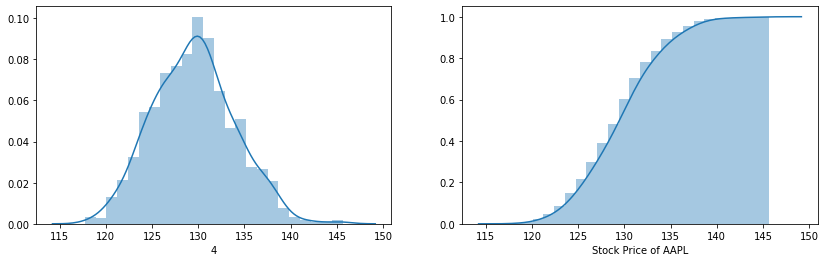

Days: 5
Expected Value: $129.53
Return: 0.38%

			Simulation of AMZN distribution


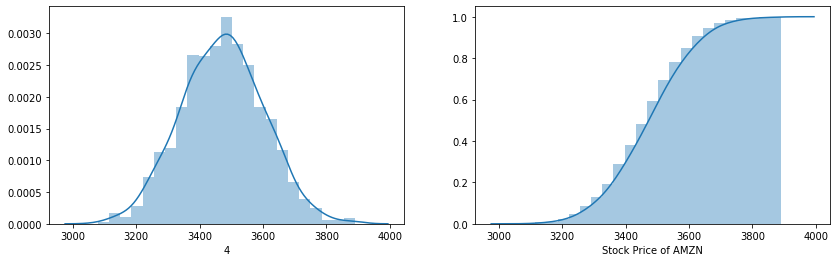

Days: 5
Expected Value: $3472.44
Return: 0.62%

			Simulation of FB distribution


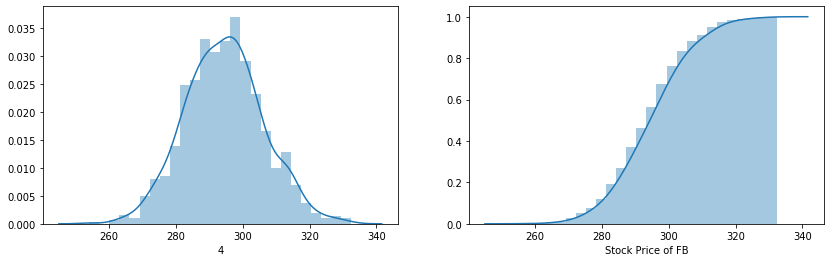

Days: 5
Expected Value: $294.49
Return: 0.44%

			Simulation of NFLX distribution


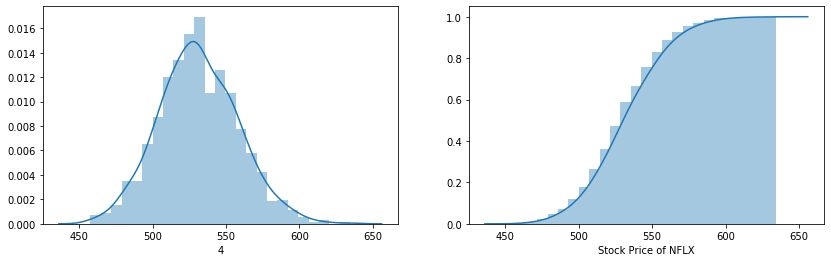

Days: 5
Expected Value: $531.17
Return: 0.3%

			Simulation of GOOG distribution


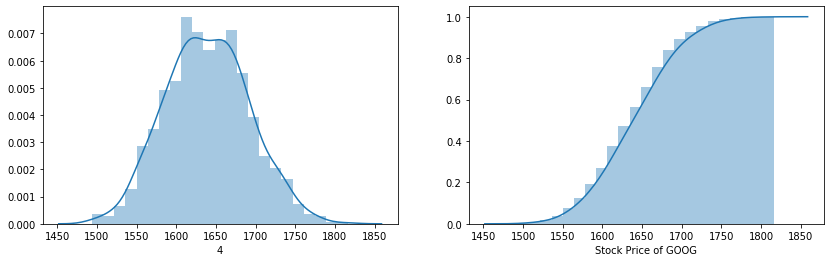

Days: 5
Expected Value: $1639.19
Return: 0.31%

			Simulation of GC=F distribution


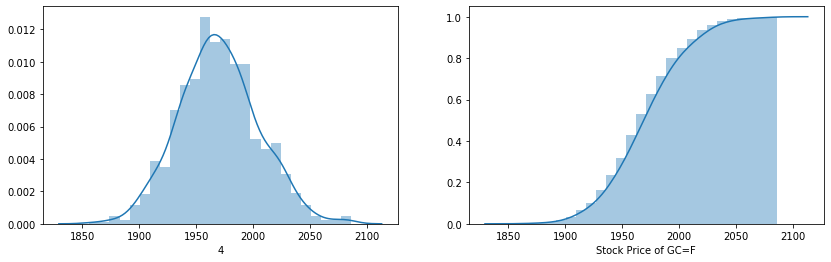

Days: 5
Expected Value: $1969.92
Return: 0.12%

			Simulation of BZ=F distribution


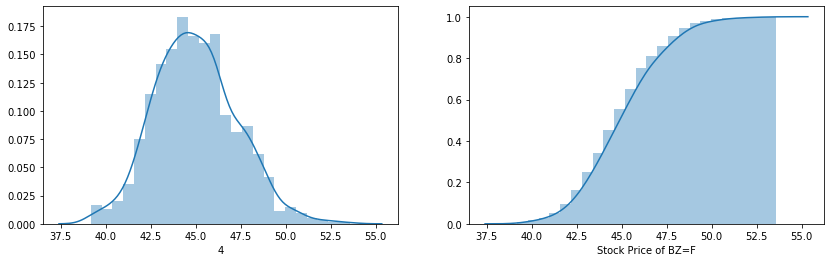

Days: 5
Expected Value: $45.0
Return: -0.23%



In [31]:
prediction_AAPL = stock_price_simulation('AAPL')
prediction_AMZN = stock_price_simulation('AMZN')
prediction_FB = stock_price_simulation('FB')
prediction_NFLX = stock_price_simulation('NFLX')
prediction_GOOG = stock_price_simulation('GOOG')
prediction_GC_F = stock_price_simulation('GC=F')
prediction_BZ_F = stock_price_simulation('BZ=F')

## ML Prediction

Create columns with shifted data

In [32]:
def shifted_data(df, forecast_out=5):
    #set how many days in the future we predict
    for i in df.columns:
        df['Forecast_'+i] = df[[i]].shift(-forecast_out)
    return df

In [33]:
data_for_prediction = shifted_data(all_stocks)[:-5].reset_index()

Train the linear models and assess how accurate is it.

In [34]:
def linear_prediction(ticker):
    #split data to training 80% and testing 20%
    x_train, x_test, y_train, y_test = train_test_split(np.array(data_for_prediction.loc[:,[ticker]]), data_for_prediction['Forecast_{}'.format(ticker)], test_size=0.2)    
    
    #The last 5 days' data will be used later when we will make predictions, so save it separately from the rest data
    x_forecast = np.array(all_stocks[[ticker]])[-5:]
    
    #Create and train linear regression model
    lr = LinearRegression()
    lr = lr.fit(x_train, y_train)
    
    #Check how good model is using  𝑅2
    lr_conf = lr.score(x_test, y_test)
    print("lr confidence for {}".format(ticker),lr_conf)
    
    if lr_conf >= 0.85:
        print("Since the model showed a great result in the R^2 metric we will use it to predict stock prices for the next 5 days")
    lr_predict = lr.predict(x_forecast)
    print()
    return lr_predict

In [35]:
lr_predict_AAPL = linear_prediction('AAPL')
lr_predict_AMZN = linear_prediction('AMZN')
lr_predict_FB = linear_prediction('FB')
lr_predict_GOOG= linear_prediction('GOOG')
lr_predict_NFLX = linear_prediction('NFLX')
lr_predict_GC_F = linear_prediction('GC=F')
lr_predict_BZ_F = linear_prediction('BZ=F')

lr confidence for AAPL 0.9917474771164377
Since the model showed a great result in the R^2 metric we will use it to predict stock prices for the next 5 days

lr confidence for AMZN 0.9939754740714206
Since the model showed a great result in the R^2 metric we will use it to predict stock prices for the next 5 days

lr confidence for FB 0.9856542012458714
Since the model showed a great result in the R^2 metric we will use it to predict stock prices for the next 5 days

lr confidence for GOOG 0.9899300415686175
Since the model showed a great result in the R^2 metric we will use it to predict stock prices for the next 5 days

lr confidence for NFLX 0.9898907310304936
Since the model showed a great result in the R^2 metric we will use it to predict stock prices for the next 5 days

lr confidence for GC=F 0.9741763582139311
Since the model showed a great result in the R^2 metric we will use it to predict stock prices for the next 5 days

lr confidence for BZ=F 0.9796566463608611
Since the mo

##  Compare results

Now we can compare predicted data by Linear Regression algorithm with expectations produced by Monte Carlo method.

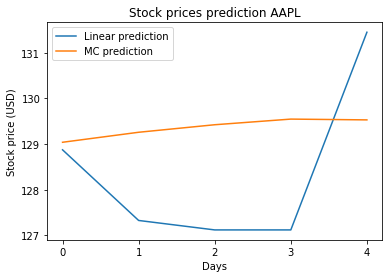

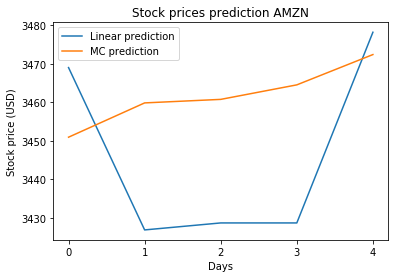

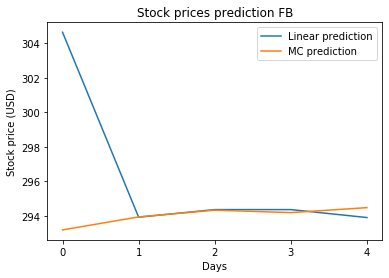

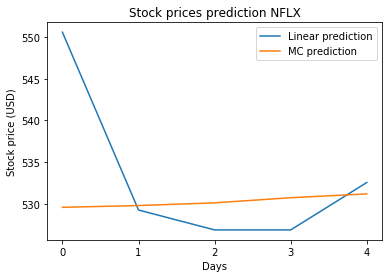

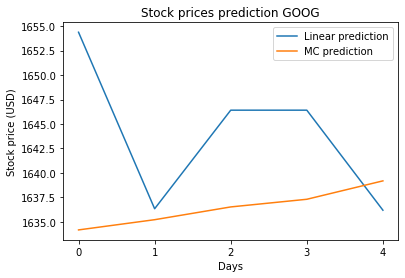

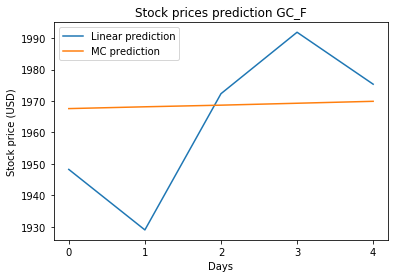

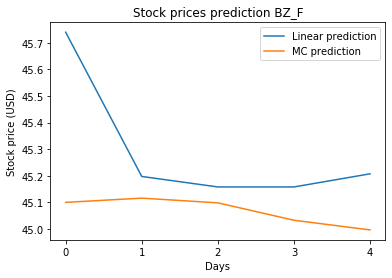

In [37]:
for t in Tickers_titles:
    exec(f'plt.plot(lr_predict_{t})')
    exec(f'plt.plot(pd.DataFrame(prediction_{t}).T.mean())')
    plt.title('Stock prices prediction '+t)
    plt.ylabel('Stock price (USD)')
    plt.xlabel('Days')
    plt.xticks([0, 1,2,3,4])
    plt.legend(['Linear prediction', 'MC prediction'])
    plt.show()

As we can see results produced by ML and MC pretty close, we can use one of them or take the average.

## Visualization of the predicted portfolio value.

And finaly we can join all results. Say we bought 100 stocks accordigly to the optimal porfolio that we built, and let's check what dynamic would be the next 5 predicted days.

In [38]:
lr_portfolio_prediction = lr_predict_AAPL*w_opt_porf['AAPL']*100+lr_predict_AMZN*w_opt_porf['AMZN']*100+lr_predict_FB*w_opt_porf['FB']*100+lr_predict_GOOG*w_opt_porf['GOOG']*100+lr_predict_NFLX*w_opt_porf['NFLX']*100+lr_predict_GC_F*w_opt_porf['GC=F']*100+lr_predict_BZ_F*w_opt_porf['BZ=F']*100

In [39]:
lr_portfolio_prediction = pd.DataFrame(lr_portfolio_prediction)

In [40]:
MC_portfolio_prediction = pd.DataFrame(prediction_AAPL).T.mean()*w_opt_porf['AAPL']*100+pd.DataFrame(prediction_AMZN).T.mean()*w_opt_porf['AMZN']*100+pd.DataFrame(prediction_FB).T.mean()*w_opt_porf['FB']*100++pd.DataFrame(prediction_GOOG).T.mean()*w_opt_porf['GOOG']*100+pd.DataFrame(prediction_NFLX).T.mean()*w_opt_porf['NFLX']*100+pd.DataFrame(prediction_GC_F).T.mean()*w_opt_porf['GC=F']*100+pd.DataFrame(prediction_BZ_F).T.mean()*w_opt_porf['BZ=F']*100

In [41]:
MC_portfolio_prediction=pd.DataFrame(MC_portfolio_prediction)

In [42]:
portfolio_prediction_merged = pd.merge(lr_portfolio_prediction, MC_portfolio_prediction, how='inner', left_index=True, right_index=True)

In [43]:
portfolio_prediction_merged.set_index(np.array(range(1,6)), drop=True, inplace=True)

In [44]:
portfolio_prediction_merged = portfolio_prediction_merged/1000

In [45]:
portfolio_prediction_merged = portfolio_prediction_merged.rename(columns = {'0_x':'LR Prediction', '0_y':'MC Prediction'})

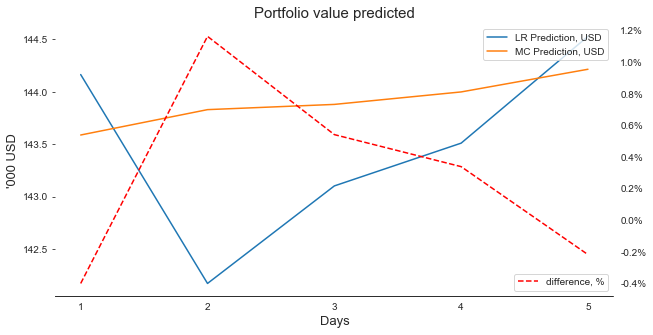

In [46]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(portfolio_prediction_merged, label=portfolio_prediction_merged.columns)
ax.legend(['LR Prediction, USD', 'MC Prediction, USD'], loc =1)
plt.title('Portfolio value predicted', fontsize=15)
plt.xlabel('Days', fontsize=13)
ax.plot()
plt.ylabel('\'000 USD', fontsize=13)
ax2 =ax.twinx()
ax2.plot((portfolio_prediction_merged.iloc[:,1]/portfolio_prediction_merged.iloc[:,0]-1), color='Red', ls='--')
ax2.legend(['difference, %'], loc =4)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)
ax2.spines['right'].set_color('white')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

plt.show()

As we can see we don't have significant differences between ML and MC predictions. Thus we can choose any of them or calculate the mean.